# The Electromagnetic Spectrum

People having been staring at the night sky for millenia, and (we now know) interpreting an incoming stream of photons roughly in the 380 to 760 nm range. Modern astronomers have bigger and better instruments, so the usable frequency / wavelength / energy range covers more like 20 orders of magnitude. 

This is a relatively simple notebook to help visualize where things fit on the spectrum.

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, Layout, Output
import ipywidgets as w

from astropy import units as u
from astropy.constants import c, h

from wavelength_rgb import wavelength_RGB # local file

plt.rcParams.update({'font.size': 16})

We can characterize a photon by wavelength $\lambda$ (m), frequency $\nu$ (Hz) or energy (eV). In practice, conventions about which is most useful differ for work in the various regions of the spectrum, and it is useful to be able to interconvert.

Calculations are based on the formulae $\lambda \nu = c$ and $E = h \nu$, where $c$ is the speed of light and $h$ is the Planck constant.

Define a function to take a value in one unit and calculate the other two:

In [2]:
def calcPhotonVals(value, unit):
    returnValues = {}
    if unit == 'Hz':
        returnValues['freq'] = value * u.Hz
        returnValues['wlen'] = (c / returnValues['freq']).to(u.m)
        returnValues['energy'] = (h * returnValues['freq']).to(u.eV)
    elif unit == 'm':
        returnValues['wlen'] = value * u.m
        returnValues['freq'] = (c / returnValues['wlen']).to(u.Hz)
        returnValues['energy'] = (h * returnValues['freq']).to(u.eV)
    elif unit == 'eV':
        returnValues['energy'] = value * u.eV
        returnValues['freq'] = (returnValues['energy'] / h).to(u.Hz)
        returnValues['wlen'] = (c / returnValues['freq']).to(u.m)
    else:
        raise Exception("unit {} is not in ['Hz', 'm', 'eV']".format(unit))
        
    return returnValues

Labelling the various parts of the spectrum is imprecise and there are no hard boundaries, but let's define approximate ranges:

In [17]:
def makeSpectrumDict():
    """ Data dictionary entries are tuples of wavelength in m
        (lower, upper, position), where position is just a hint for
        where to print the label along the graph's x-axis
        
        return: data dictionary and a list of boundary wavelengths
    """
    dd = {'gamma': (0, 1e-11, 1e-12),
        'X-ray': (1e-11, 1e-8, 1e-10),
        'UV': (1e-8, 3.8e-7, 1e-7),
        'vis': (3.8e-7, 7.6e-7, 3.3e-7),
        'NIR': (7.6e-7, 2.5e-6, 9e-7),
        'MIR': (2.5e-6, 1e-5, 3e-6),
        'FIR': (1e-5, 1e-3, 3e-5),
        'microwave': (1e-3, 0.1, 2e-3),
        'radio': (0.1, 1e8, 1) } # top end arbitrary
    boundaries = [v[0] for v in dd.values()]
    return (dd, boundaries)

Next define the plot routine. The x-axis is important (log scale), the y-axis is just dummy values to define vertical positions.

In [30]:
def plotPhotonData(value, unit):
    valDict = calcPhotonVals(value, unit)
    spectrumDict, boundaries = makeSpectrumDict()
    
    # set up the full gamma-to-radio range
    fig = plt.figure(figsize=(18,5))
    ax = plt.axes()
    plt.plot((1e-12,1e3), (0.1, 0.1))
    for boundary in boundaries:
        plt.plot(boundary, 0.1, 'o', color='lightgray', markersize = 10)
    for name, limits in spectrumDict.items():
        plt.text(limits[2], 0.15, name)
    
    # show the current input value graphically
    curr_wlen = valDict['wlen'].value
    
    # for visible, try to represent the actual color (all others black)
    # wavelength_RGB() needs wavelength in nm, returns 0-255 integers
    wlen_color = [c/255.0 for c in wavelength_RGB(curr_wlen*1e9)] 
    
    # an arrow would be good, but I didn't get that working correctly yet
    plt.plot((curr_wlen, curr_wlen), (0.3, 0.45), color=wlen_color)
        
    # matplotlib housekeeping
    plt.xscale("log", nonposx='clip')
    plt.xticks([10**n for n in (-12, -9, -6, -3, 0, 3)])
    plt.xlabel('wavelength $\lambda$ (m)')
    plt.ylim(bottom=0, top=1)
    ax.yaxis.set_visible(False)
    plt.title('Electromagnetic Spectrum')
    
    # add results for current input as text
    plt.text(1e-11, 0.8, 'Wavelength: {:.3e}'.format(valDict['wlen']))
    plt.text(1e-11, 0.7, 'Frequency: {:.3e}'.format(valDict['freq']))
    plt.text(1e-11, 0.6, 'Energy: {:.3e}'.format(valDict['energy']))

Now define some simple interactive widgets. The Value box just needs to be something Python can interpret as a floating-point number. Given the range of useful numbers, either scientific notation (`1.2e-3`) or an expression (`1.2*10**(-3)`)  may be useful. ___No___ units in here!

TODO: Handling related units (nm, MeV) would be a useful future enhancement.

In [31]:
interact(plotPhotonData, value = w.FloatText(description="Value:",
                                        value=4.7e-7,
                                        disabled=False),
                         unit = w.RadioButtons(description='units:',
                                        options=['Hz', 'm', 'eV'],
                                        value='m',
                                        disabled=False
                                        ));

interactive(children=(FloatText(value=4.7e-07, description='Value:'), RadioButtons(description='units:', index…

In the visible range (an extremely narrow part of the above plot!), how do the various wavelengths look to our eyes? That soulds like a simple question but it really isn't!  There is no single, accurate answer (after a lot of scientific study, not least by computer graphics card manufacturers such as Nvidia).  

One rough, approximate answer is implemented in `wavelength_RGB()`, in the external file `wavelength_rgb.py` (it's mostly a lot of long and boring if..elif..else statements).

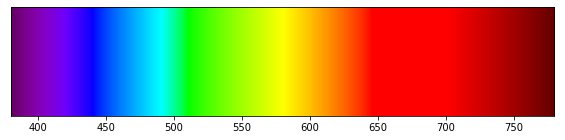

In [6]:
from PIL import Image
from matplotlib.pyplot import imshow

lmin = 380 # nm
lmax = 780
lambdas = np.arange(lmin,lmax,0.5)
colors = [wavelength_RGB(l) for l in lambdas]
h = 80 # pixel height for plot

# Create a new black image
img = Image.new( 'RGB', (len(colors),h), "black") 
pixels = img.load() 

# set the colors
for i in range(len(colors)):   
    pixels[i,0] = colors[i]
    for j in range(1,h):
        pixels[i,j] = pixels[i,0]

fig, ax = plt.subplots(figsize=(30, 2))
ims = ax.imshow(np.asarray(img), extent = [lmin,lmax,0,h]);
ims.axes.get_yaxis().set_visible(False);